In [34]:
from selenium import webdriver
import numpy as np
import requests
import pandas as pd
from bs4 import BeautifulSoup
#from re import sub
import matplotlib.pyplot as plt
from scipy import stats
import time


In [2]:
def createUrl(keyword,n=None,pageitems=None,sold=False):
  Url=f"https://www.ebay.com/sch/i.html?_nkw={keyword}"
  if n:
    Url+=f"&_pgn={n}"
  if pageitems:
    if pageitems in [200,100,50,25,10,5]:
      Url+=f"&_ipgn={pageitems}"
    else:
      print("Error items perpage")
      print("Options: 200,100,50,25,10,5")
  if sold:
    Url+="&LH_Sold=1"
  return Url 

In [100]:
def ebay_SoldListingToPanda(listings,showprint=False):
    dictionary_list = []
    
    for i in range(0,len(listings)):
        dictionary_data = {}
        name=listings[i].find("h3",attrs={"class":f"s-item__title"})
        if name.text !="":
            name=name.text
            dictionary_data["name"]=name

            solddate=listings[i].find("div",attrs={"class":f"s-item__title--tag"}).text

            dictionary_data["sold_date"]=solddate.replace("Item","").replace("Sold","")

            condition=listings[i].find("span",attrs={"class":f"SECONDARY_INFO"}) #.text
            if condition==None:
                condition=""
            else:
                condition=condition.text
            dictionary_data["condition"]=condition

            #Sold price
            priceinfo=listings[i].find("div",attrs={"class":f"s-item__details clearfix"})
            #dictionary_data["price_info"]=priceinfo
            soldprice=priceinfo.find("span",attrs={"class":'s-item__price'}).text
            #Currany & cost 
            currency=soldprice.split(" ")[0]
            soldprice=soldprice.split(" ")[1].replace(",","")
            dictionary_data["sold_price"]=int(soldprice)
            
            #Buynow
            Buytype=priceinfo.find("span",attrs={"class":'s-item__purchase-options-with-icon'})
            if Buytype==None:
                #Bid
                bids=priceinfo.find("span",attrs={"class":'s-item__bids s-item__bidCount'}).text
                Buytype=f"Bid ({bids})"
            else:
                Buytype=Buytype.text
            dictionary_data["Buytype"]=Buytype

            #Shipping info
            shippingprice=priceinfo.find("span",attrs={"class":'s-item__shipping'}).text
            shippinglocation=priceinfo.find("span",attrs={"class":'s-item__location'}).text[5:]

            dictionary_data["shipping_fee"]=shippingprice
            dictionary_data["shipping_location"]=shippinglocation
            #links 
            ref=listings[i].find("a").get("href")
            dictionary_data["ref"]=ref

            src=listings[i].find("img").get("src")
            dictionary_data["image_src"]=src

            dictionary_list.append(dictionary_data)
            
            if showprint:
                print(f"{'~'*10}")
                print(name)
                print(solddate)
                print(soldprice)
                print(Buytype)
                print(shippinglocation)
    df_final = pd.DataFrame.from_dict(dictionary_list)
    return df_final


In [101]:

def ebay_CurrentListingToPanda(listings,showprint=False):
  dictionary_list = []
  for i in range(0,len(listings)):
      dictionary_data = {}
      name=listings[i].find("h3",attrs={"class":f"s-item__title"})
      if name.text !="":
          name=name.text
          dictionary_data["name"]=name

          condition=listings[i].find("span",attrs={"class":f"SECONDARY_INFO"}) #.text
          if condition==None:
              condition=""
          else:
              condition=condition.text
          dictionary_data["condition"]=condition

          priceinfo=listings[i].find("div",attrs={"class":f"s-item__details clearfix"})
          
          price=priceinfo.find("span",attrs={"class":'s-item__price'}).text
          dictionary_data["price"]=price

          #Buynow
          Buytype=priceinfo.find("span",attrs={"class":'s-item__purchase-options-with-icon'})
          if Buytype==None:
              #Bid
              bids=priceinfo.find("span",attrs={"class":'s-item__bids s-item__bidCount'}).text
              Buytype=f"Bid ({bids})"
          else:
              Buytype=Buytype.text
          dictionary_data["Buytype"]=Buytype

          #Watch type    
          watchers=priceinfo.find("span",attrs={"class":'s-item__hotness s-item__itemHotness'})
          if watchers !=None:
              watchers=(watchers.text)[:watchers.text.find("w")-1]
              print(watchers)
              dictionary_data["watchers"]=watchers
          else:
              dictionary_data["watchers"]=0

          #Shipping info
          shippingprice=priceinfo.find("span",attrs={"class":'s-item__shipping'}).text
          shippinglocation=priceinfo.find("span",attrs={"class":'s-item__location'}).text[5:]

          dictionary_data["shipping_fee"]=shippingprice
          dictionary_data["shipping_location"]=shippinglocation
          #links 
          ref=listings[i].find("a").get("href")
          dictionary_data["ref"]=ref

          src=listings[i].find("img").get("src")
          dictionary_data["image_src"]=src

          dictionary_list.append(dictionary_data)
          
          if showprint:
              print(f"{'~'*10}")
              print(name)
              print(price)
              print(Buytype)
              print(shippinglocation)
  df_final = pd.DataFrame.from_dict(dictionary_list)  
  return df_final

In [171]:
def Ebay_MarketData(URL,pagenumbers,browser,test=False): 
  sold=False
  itemclass="s-item"
 # if "LH_Sold=1" in URL:
 #   sold=True
 #   itemclass="s-item__wrapper clearfix"
  MarketData=pd.DataFrame()
  for i in range(1,pagenumbers):
      if "_pgn" in URL:
        pgnloc=URL.find("_pgn")
        URL[pgnloc+6]=str(i)
        ebayUrl=URL
      else:
        ebayUrl=URL+f"&_pgn={i}"
      browser.get(ebayUrl)
      #time.sleep(1)
      #Catch 対策
      first=True
      while browser.title=='Security Measure':
        if first:
          print("waiting for human help")
          first=False
          print(browser.title)
      else:
        pass
     # print(r.raise_for_status())
      data=browser.page_source
      soup=BeautifulSoup(data)
      if test:
        return soup
      listings = soup.find_all('li', attrs={'class': itemclass})
      L=len(listings) 
      if i==1:
        Lsave=L

      if sold:
        page_df=ebay_SoldListingToPanda(listings)
      else:
        page_df=ebay_SoldListingToPanda(listings)
      MarketData=pd.concat([MarketData,page_df],axis=0,ignore_index=True)
      
      if L < Lsave: #Hit result item limit 
        print(len(MarketData))
        return MarketData

  
  return MarketData
      


    
            # 

In [163]:

driverpath="chromedriver.exe"
brave="C:/Program Files/BraveSoftware/Brave-Browser/Application/brave.exe"
option = webdriver.ChromeOptions()
option.binary_location = brave
browser = webdriver.Chrome(executable_path=driverpath, chrome_options=option)

<ipython-input-163-1c71eee34bd9>:5: DeprecationWarning: use options instead of chrome_options
  browser = webdriver.Chrome(executable_path=driverpath, chrome_options=option)


In [170]:
dataset={}
Wifus=["Yuuki Asuna","Zero two","Rem"]

for Wifu in Wifus:
  URL=createUrl(Wifu+" figure",pageitems=200,sold=True)
  print(URL)
  Wdata= Ebay_MarketData(URL,10,browser)

  #Data　processins 処理
  Wdata.sold_date=pd.to_datetime(Wdata.sold_date)
  Wdata=Wdata.drop_duplicates(keep='first')
  dataset[Wifu]=Wdata



https://www.ebay.com/sch/i.html?_nkw=Yuuki Asuna figure&_ipgn=200&LH_Sold=1
https://www.ebay.com/sch/i.html?_nkw=Zero two figure&_ipgn=200&LH_Sold=1
https://www.ebay.com/sch/i.html?_nkw=Rem figure&_ipgn=200&LH_Sold=1


In [172]:
Wdata.columns

Index(['name', 'sold_date', 'condition', 'sold_price', 'Buytype',
       'shipping_fee', 'shipping_location', 'ref', 'image_src'],
      dtype='object')

In [173]:
bels,data=[*zip(*dataset.items())] #Transpose
# or backwards compatable    
labels, data = dataset.keys(), dataset.values()
data=[k[1]["sold_price"] for k in dataset.items()]
labels=[k[0] for k in dataset.items()]

([<matplotlib.axis.XTick at 0x1bfcf5dd040>,
 [Text(1, 0, 'Yuuki Asuna'), Text(2, 0, 'Zero two'), Text(3, 0, 'Rem')])

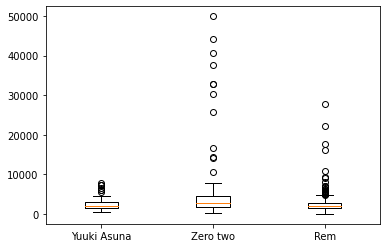

In [174]:
plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels)

TypeError: bar() missing 1 required positional argument: 'height'

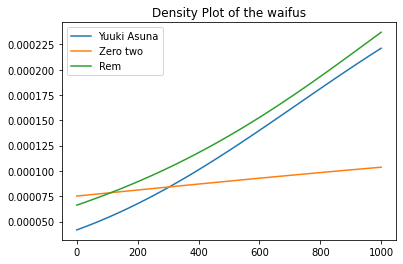

In [175]:
from scipy.stats import kde
#https://www.delftstack.com/ja/howto/matplotlib/matplotlib-density-plot/
x=np.linspace(0,1000,100)
for i in range(0,len(labels)):
  density = kde.gaussian_kde(data[i])
  plt.plot(x,density(x),label=labels[i])
  plt.title("Density Plot of the waifus")
plt.legend()

<ipython-input-232-33d212c5b92b>:17: RuntimeWarning: divide by zero encountered in true_divide
  dayNvolume[key]=(dayvolume.values/daycount.values)[0]
<ipython-input-232-33d212c5b92b>:17: RuntimeWarning: invalid value encountered in true_divide
  dayNvolume[key]=(dayvolume.values/daycount.values)[0]
<ipython-input-232-33d212c5b92b>:17: RuntimeWarning: divide by zero encountered in true_divide
  dayNvolume[key]=(dayvolume.values/daycount.values)[0]
<ipython-input-232-33d212c5b92b>:17: RuntimeWarning: invalid value encountered in true_divide
  dayNvolume[key]=(dayvolume.values/daycount.values)[0]


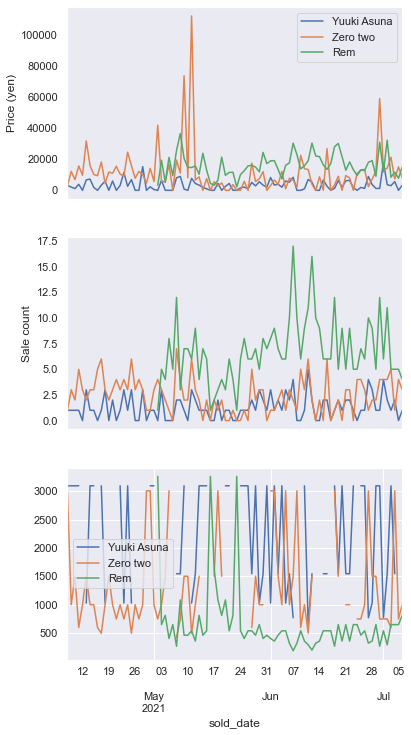

In [232]:
#毎日のVolume
fig,axs=plt.subplots(3,1,figsize=(6,12))
for key,Wdata in dataset.items():  
    Wdata.sold_date=pd.to_datetime(Wdata.sold_date)
    Wdata.index=Wdata.sold_date
    dayvolume=Wdata.resample("1d").sum()
    daycount=Wdata.resample("1d").count()["sold_price"]
    daystd=Wdata.resample("1d").std()
    dayvolume.columns=[key]
    dayvolume.plot(ax=axs[0])
    
    #ax.plot(dayvolume["sold_price"],label=key)
    #Sales Count 
    daycount.plot(ax=axs[1],sharex=axs[0])
     #normalized volume 
    dayNvolume=dayvolume.copy()
    dayNvolume[key]=(dayvolume.values/daycount.values)[0]
    
    dayNvolume.dropna().plot(ax=axs[2])

axs[0].set_ylabel("Price (yen)")
axs[1].set_ylabel("Sale count")

plt.setp(axs[0].get_xticklabels(), visible=False)
axs[0].legend()
axs[0].grid()
axs[1].grid()

In [231]:
dayNvolume.dropna()

,Rem
sold_date,
2021-05-02,3262.000000
2021-05-03,652.400000
2021-05-04,815.500000
2021-05-05,407.750000
2021-05-06,652.400000
...,...
2021-07-02,296.545455
2021-07-03,652.400000
2021-07-04,652.400000


In [227]:
dayvolume["test"]=(dayvolume.values/daycount.values)[0]

In [183]:
fulldata=pd.DataFrame()
for key,Wdata in dataset.items(): 
    Wdata.sold_date=pd.to_datetime(Wdata.sold_date)
    #Wdata.index=Wdata.sold_date
    Wdata["Waifu"]=key
    fulldata=pd.concat([fulldata,Wdata],axis=0,ignore_index=True)

    #dayvolume=Wdata.resample("1d").sum()
    #daycount=Wdata.resample("1d").count()["sold_price"] 

In [188]:
import seaborn as sns
sns.set(style='darkgrid')
fulldata.columns

Index(['name', 'sold_date', 'condition', 'sold_price', 'Buytype',
       'shipping_fee', 'shipping_location', 'ref', 'image_src', 'Waifu'],
      dtype='object')

<AxesSubplot:xlabel='sold_date', ylabel='sold_price'>

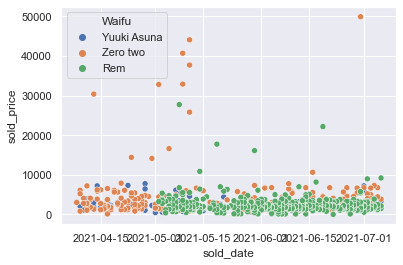

In [190]:
sns.scatterplot(data=fulldata, x='sold_date', y='sold_price', hue='Waifu')

In [212]:
#Shipping location split?
shiploc_counts=fulldata.groupby(["shipping_location"]).count().iloc[:,1] #.nlargest(4)
shiplocs=list(shiploc_counts.index)
shiploc_main=shiploc_counts.nlargest(4)
shiploc_main
#Updata date fir main ship locs, replace less than main wiht other 
for loc in shiplocs:
    if loc not in list(shiploc_main.index): #Replace with other 
        fulldata.loc[fulldata[fulldata["shipping_location"]==loc].index,"shipping_location"]="Other"

In [206]:
list(shiploc_main.index)

['China', 'Japan', 'United Kingdom', 'United States']

<AxesSubplot:xlabel='Waifu', ylabel='sold_price'>

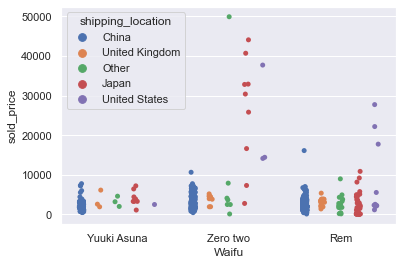

In [214]:

sns.stripplot(data=fulldata,x="Waifu",y="sold_price",hue="shipping_location",dodge=True)